# MODELO DE PREDICCIÓN DE FUGA DE CLIENTES

## OBJETIVO

El presente proyecto tiene como objetivo realizar modelos para predecir la fuga de clientes en la empresa TelecomX. Para esto, se utilizarán modelos de Machine Learning y se compararán las métricas obtenidas para elegir el mejor modelo que pueda predecir la fuga de clientes.

## IMPORTACIÓN DE LIBRERÍAS Y DATOS

In [132]:
# Importación de librerías

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance


In [133]:
# Importación de datos

datos = pd.read_csv('dataframe_telecom1.csv')
datos.head()

,churn,cust_gender,cust_senior_citizen,cust_partner,cust_dependents,cust_tenure,cust_tenure_int,phone_service,phone_multiple_lines,internet_service,...,device_protection,tech_support,streaming_tv,streaming_movies,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,daily_charges
0,0,0,0,1,1,9,6-10,1,No,1,...,No,Yes,Yes,No,One year,1,Mailed check,65.6,593.30,2.19
1,0,1,0,0,0,9,6-10,1,Yes,1,...,No,No,No,Yes,Month-to-month,0,Mailed check,59.9,542.40,2.00
2,1,1,0,0,0,4,0-5,1,No,1,...,Yes,No,No,No,Month-to-month,1,Electronic check,73.9,280.85,2.46
3,1,1,1,1,0,13,11-15,1,No,1,...,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,98.0,1237.85,3.27
4,1,0,1,1,0,3,0-5,1,No,1,...,No,Yes,Yes,No,Month-to-month,1,Mailed check,83.9,267.40,2.80


El diccionario del dataframe final es el siguiente:
- 'churn': si el cliente dejó o no la empresa. Sí = 1 y No = 0.
- 'cust_gender': género del cliente. Masculino = 1 y Femenino = 0.
- 'cust_senior_citizen': información sobre si un cliente tiene o no una edad igual o mayor a 65 años. Sí = 1 y No = 0.
- 'cust_partner': si el cliente tiene o no una pareja. Sí = 1 y No = 0.
- 'cust_dependents': si el cliente tiene o no dependientes. Sí = 1 y No = 0.
- 'cust_tenure': meses de contrato del cliente.
- 'cust_tenure_int': intervalo de antiguedad en meses a la que pertenece el valor de 'cust_tenure'
- 'phone_service': suscripción al servicio telefónico. Sí = 1 y No = 0.
- 'phone_multiple_lines': suscripción a más de una línea telefónica.
- 'internet_service': suscripción al servicio de internet. Sí = 1 y No = 0.
- 'internet_type': tipo de servicio de internet contratado.
- 'online_security': suscripción adicional de seguridad en línea.
- 'online_backup': suscripción adicional de respaldo en línea.
- 'device_protection': suscripción adicional de protección del dispositivo.
- 'tech_support': suscripción adicional de soporte técnico, menor tiempo de espera.
- 'streaming_tv': suscripción de televisión por cable.
- 'streaming_movies': suscripción de streaming de películas.
- 'contract_type': tipo de contrato.
- 'paperless_billing': si el cliente prefiere recibir la factura en línea.  Sí = 1 y No = 0.
- 'payment_method': forma de pago.
- 'monthly_charges': total de todos los servicios del cliente por mes.
- 'total_charges': total gastado por el cliente.
- 'daily_charges': total de todos los servicios del cliente por día.

## ANÁLISIS EXPLORATORIO DE LOS DATOS

Se realizará un análisis exploratorio del dataframe importado para poder verificar:
- Qué columnas del dataframe no aportan información para el modelo.
- Qué transformaciones son necesarias realizar a las variables explicativas.
- Si los datos disponibles de la fuga de clientes están balanceados o no.

In [134]:
# Metadatos del dataframe
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   churn                 7043 non-null   int64  
 1   cust_gender           7043 non-null   int64  
 2   cust_senior_citizen   7043 non-null   int64  
 3   cust_partner          7043 non-null   int64  
 4   cust_dependents       7043 non-null   int64  
 5   cust_tenure           7043 non-null   int64  
 6   cust_tenure_int       7043 non-null   object 
 7   phone_service         7043 non-null   int64  
 8   phone_multiple_lines  7043 non-null   object 
 9   internet_service      7043 non-null   int64  
 10  internet_type         7043 non-null   object 
 11  online_security       7043 non-null   object 
 12  online_backup         7043 non-null   object 
 13  device_protection     7043 non-null   object 
 14  tech_support          7043 non-null   object 
 15  streaming_tv         

In [135]:
# Verificación de datos por columna

for x in datos.columns:
    num_valores_unicos = datos[x].nunique()
    print(f'La columna {x} tiene {num_valores_unicos} valores únicos')
    if num_valores_unicos < 5:
        print(datos[x].unique())
    print('----\n')

La columna churn tiene 2 valores únicos
[0 1]
----

La columna cust_gender tiene 2 valores únicos
[0 1]
----

La columna cust_senior_citizen tiene 2 valores únicos
[0 1]
----

La columna cust_partner tiene 2 valores únicos
[1 0]
----

La columna cust_dependents tiene 2 valores únicos
[1 0]
----

La columna cust_tenure tiene 73 valores únicos
----

La columna cust_tenure_int tiene 14 valores únicos
----

La columna phone_service tiene 2 valores únicos
[1 0]
----

La columna phone_multiple_lines tiene 3 valores únicos
['No' 'Yes' 'No phone service']
----

La columna internet_service tiene 2 valores únicos
[1 0]
----

La columna internet_type tiene 3 valores únicos
['DSL' 'Fiber optic' 'No internet service']
----

La columna online_security tiene 3 valores únicos
['No' 'Yes' 'No internet service']
----

La columna online_backup tiene 3 valores únicos
['Yes' 'No' 'No internet service']
----

La columna device_protection tiene 3 valores únicos
['No' 'Yes' 'No internet service']
----

La col

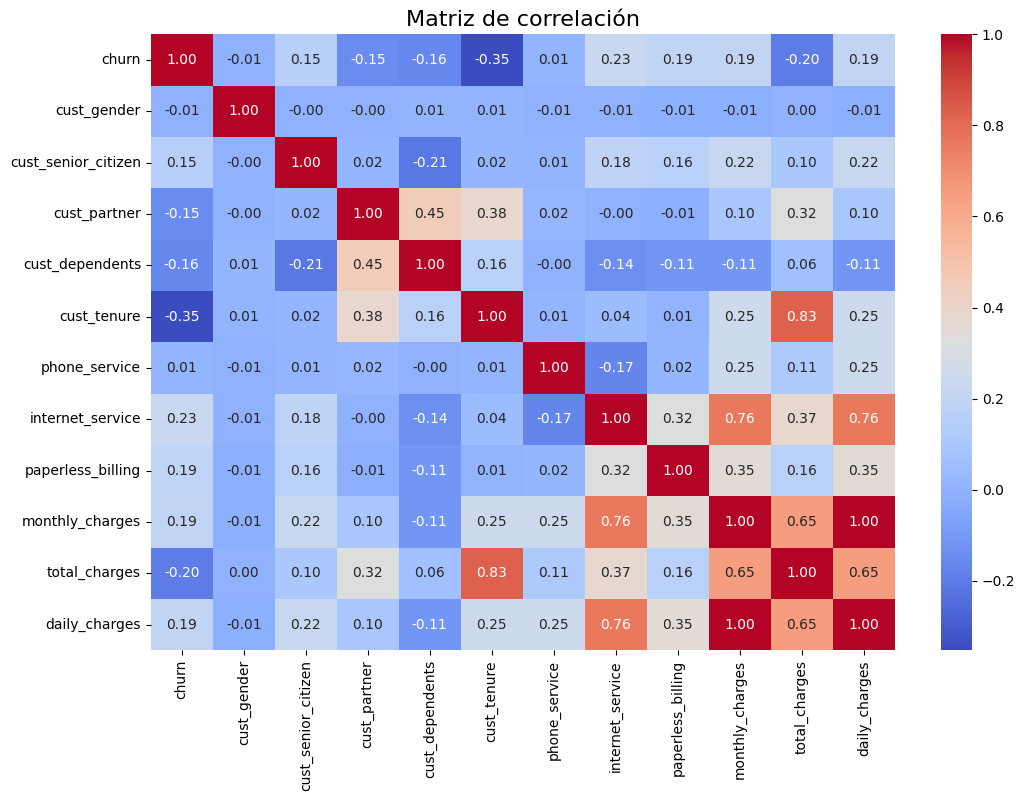

In [136]:
# Matriz de correlación

corr = datos.corr(numeric_only=True)

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación", fontsize=16)
plt.show()

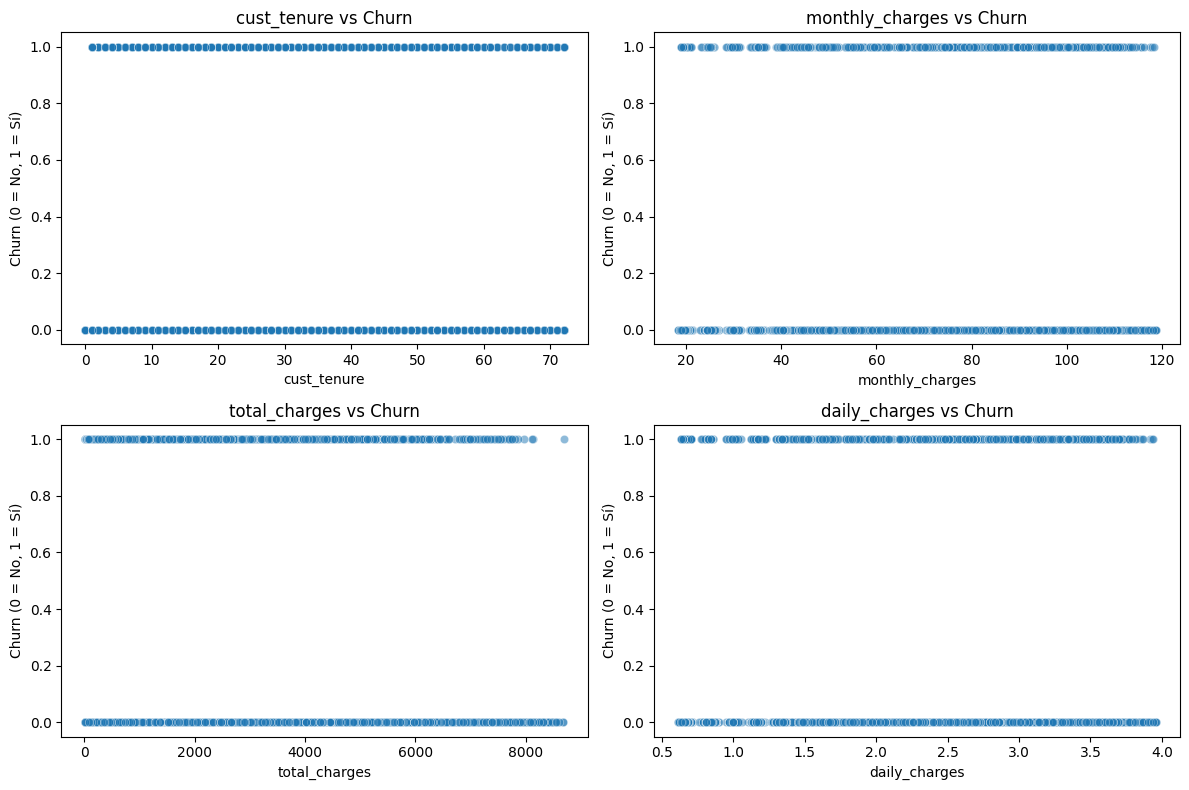

In [138]:
# Análisis de variables numericas con churn
num_vars = ['cust_tenure', "monthly_charges", "total_charges", "daily_charges"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(num_vars):
    sns.scatterplot(
        x=col, y="churn", data=datos,
        alpha=0.5, ax=axes[i]
    )
    axes[i].set_title(f"{col} vs Churn")
    axes[i].set_ylabel("Churn (0 = No, 1 = Sí)")

plt.tight_layout()
plt.show()


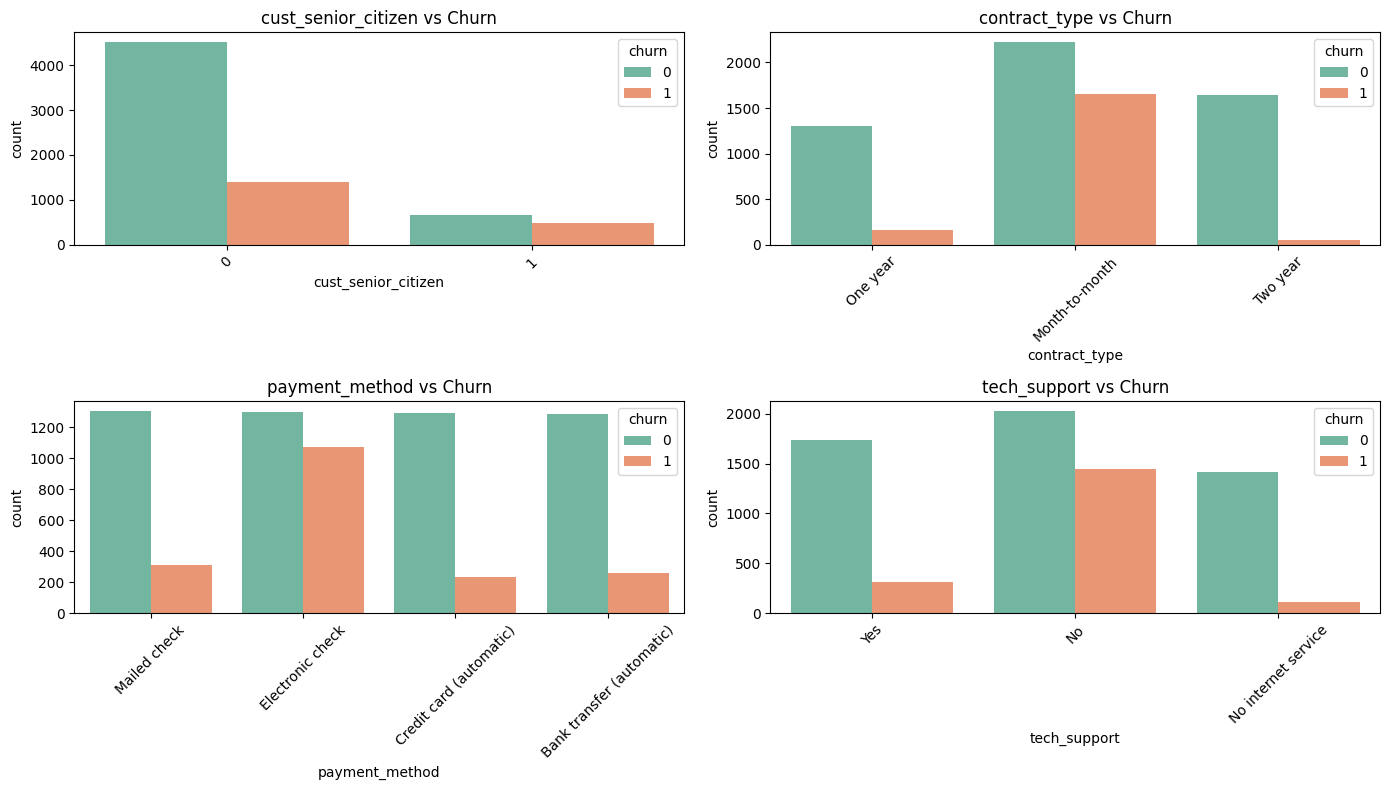

In [139]:
# Análisis de variables categoricas con churn
cat_vars = ["cust_senior_citizen", "contract_type", "payment_method", "tech_support"]

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(cat_vars):
    sns.countplot(
        x=col, hue="churn", data=datos,
        palette="Set2", ax=axes[i]
    )
    axes[i].set_title(f"{col} vs Churn")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [105]:
# Verificación del balance de datos en la columna 'churn'

datos['churn'].value_counts()

churn
0    5174
1    1869
Name: count, dtype: int64

1. El Dataframe importado tiene 23 columnas y 7043 filas.
2. La columna target ('churn') tiene datos desbalanceados, ya que la cantidad de datos correspondientes al valor 0 (No) son más de dos veces mayores a los del valor 1 (Sí).
3. De acuerdo a los datos del dataframe importado, se deben realizar las siguientes acciones:

- Eliminar la columna 'cust_tenure_int', por ser de tipo object y tener información redundante con la columna 'cust_tenure'.
- Eliminar la columna 'internet_type', por ser redundante con la columna 'internet_service'.
- Eliminar la columna 'daily_charges', pues tiene información redundate con 'monthly_charges'.
- Eliminar la columna 'total_charges', pues tiene información redundante con 'monthly_charges' y 'cust_tenure'.
- Las columnas 'phone_multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv' y 'streaming_movies' tienen 3 valores que pueden ser reducirdos a 2 valores (Yes y No).
- Se debe realizar una codificación one-hot a las siguientes columnas: 'phone_multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract_type', 'payment_method'.
- Se debe realizar un balanceo de datos para asegurar que el modelo pueda predecir correctamente la fuga de clientes.

In [106]:
# Eliminación de las columnas 'cust_tenure_int', 'internet_type', 'daily_charges' y 'total_charges'

datos_final = datos.drop(columns=['cust_tenure_int', 'internet_type', 'daily_charges', 'total_charges'])
datos_final.sample()

,churn,cust_gender,cust_senior_citizen,cust_partner,cust_dependents,cust_tenure,phone_service,phone_multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type,paperless_billing,payment_method,monthly_charges
4147,0,1,0,0,0,46,0,No phone service,1,Yes,No,Yes,Yes,Yes,Yes,Two year,1,Bank transfer (automatic),60.75


In [107]:
datos_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   churn                 7043 non-null   int64  
 1   cust_gender           7043 non-null   int64  
 2   cust_senior_citizen   7043 non-null   int64  
 3   cust_partner          7043 non-null   int64  
 4   cust_dependents       7043 non-null   int64  
 5   cust_tenure           7043 non-null   int64  
 6   phone_service         7043 non-null   int64  
 7   phone_multiple_lines  7043 non-null   object 
 8   internet_service      7043 non-null   int64  
 9   online_security       7043 non-null   object 
 10  online_backup         7043 non-null   object 
 11  device_protection     7043 non-null   object 
 12  tech_support          7043 non-null   object 
 13  streaming_tv          7043 non-null   object 
 14  streaming_movies      7043 non-null   object 
 15  contract_type        

El dataframe final tiene 19 columnas y 7043 filas.

## PROCESAMIENTO DE DATOS

In [108]:
# Separación en target y variables (features)

X = datos_final.drop(columns=['churn'])
y = datos_final['churn']

In [109]:
# Separación en datos de prueba y entrenamiento

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [110]:
# Identificar columnas categóricas y numéricas

col_categoricas = X_train.select_dtypes(include="object").columns.tolist()
col_numericas = X_train.select_dtypes(exclude="object").columns.tolist()

In [111]:
# Función para binarizar columnas 'phone_multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv' y 'streaming_movies'

def binarizar_columnas(df):
    columnas_a_modificar = [
        'phone_multiple_lines', 'online_security', 'online_backup', 'device_protection', 
        'tech_support', 'streaming_tv', 'streaming_movies'
    ]
    for col in columnas_a_modificar:
        if col in df.columns:
            df[col] = df[col].where(df[col].isin(['Yes']), 'No')
    return df

In [112]:
# Transformación de datos categóricos y numéricos

transformador_num = Pipeline(steps=[
    ("scaler", StandardScaler())
])

trnasformador_cat = Pipeline(steps=[
    ("binarizar", FunctionTransformer(binarizar_columnas)),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])


In [113]:
# Preprocesamiento: One-hot encoding y escalamiento

preprocesador = ColumnTransformer(
    transformers=[
        ("num", transformador_num, col_numericas),
        ("cat", trnasformador_cat, col_categoricas)
    ]
)

## MODELOS DE MACHINE LEARNING

In [114]:
# Modelos a evaluar

modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

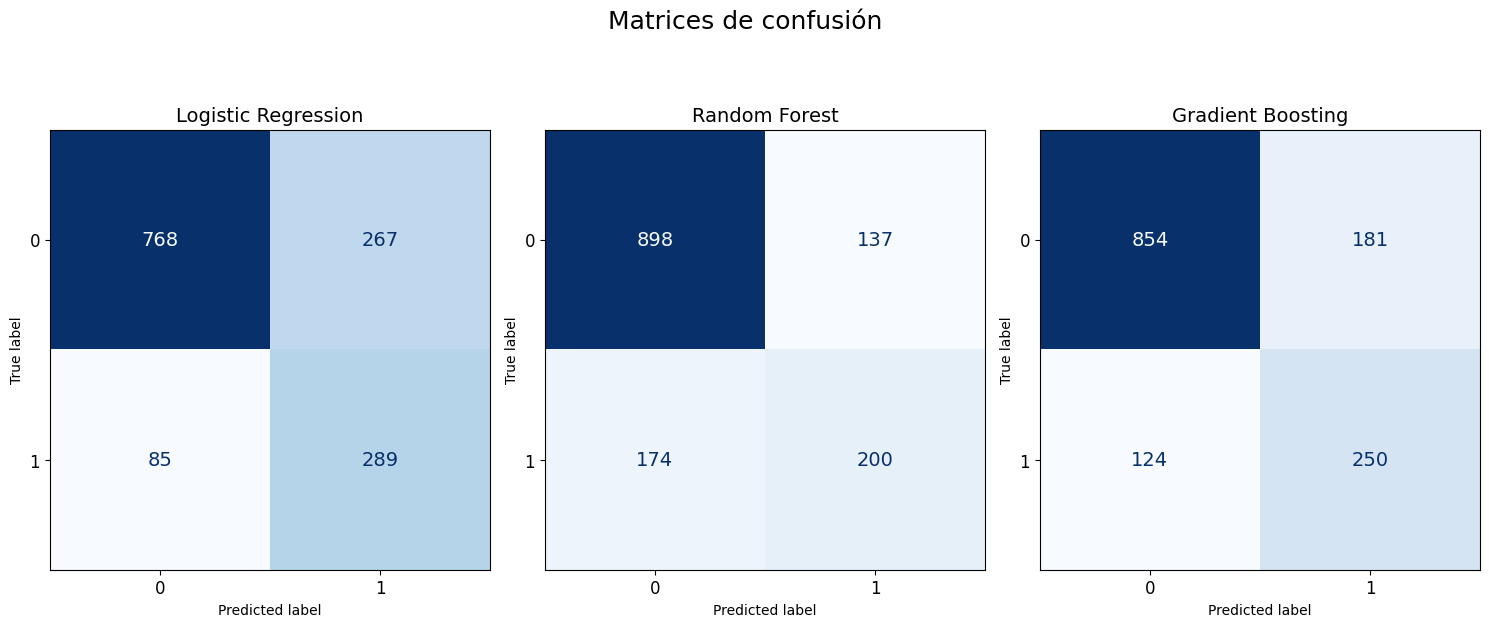

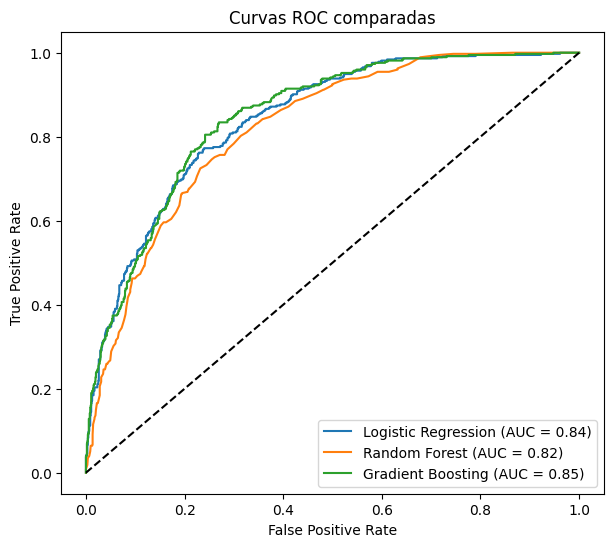


📊 Comparación de modelos:

                Modelo  Accuracy    Recall  Precision  F1-score       AUC
0  Logistic Regression  0.750177  0.772727   0.519784  0.621505  0.841383
1        Random Forest  0.779276  0.534759   0.593472  0.562588  0.819904
2    Gradient Boosting  0.783534  0.668449   0.580046  0.621118  0.846990


In [126]:
# Balanceo de datos, ejecución de modelos y resultados

datos_roc = []
metricas_lista = []

# Figura matrices de confusión
fig_cm, axes_cm = plt.subplots(1, 3, figsize=(15, 6))

for i, (nombre, modelo) in enumerate(modelos.items()):
    pipeline = ImbPipeline(steps=[
        ('preprocesador', preprocesador),
        ('smote', SMOTE(random_state=42)),
        ('model', modelo)
    ])
    
    # Entrenar
    pipeline.fit(X_train, y_train)
    
    # Predicciones
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, pos_label=1)
    prec = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    metricas_lista.append({
        "Modelo": nombre,
        "Accuracy": acc,
        "Recall": rec,
        "Precision": prec,
        "F1-score": f1,
        "AUC": auc
    })
    
    # Guardar datos para curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
    datos_roc.append((nombre, fpr, tpr, auc))
    
    # Matriz de confusión en subplot
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=axes_cm[i], cmap='Blues', colorbar=False)
    axes_cm[i].set_title(nombre, fontsize=14)  
    axes_cm[i].tick_params(axis='both', labelsize=12)  
    for text in disp.text_.ravel():
        text.set_fontsize(14) 

# Ajustar layout matrices de confusión
plt.tight_layout()
fig_cm.suptitle("Matrices de confusión", fontsize=18)
fig_cm.subplots_adjust(top=0.8)
plt.show()

# Curva ROC combinada
plt.figure(figsize=(7, 6))
for nombre, fpr, tpr, auc in datos_roc:
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparadas")
plt.legend()
plt.show()

# DataFrame de métricas
df_metricas = pd.DataFrame(metricas_lista)
print("\n📊 Comparación de modelos:\n")
print(df_metricas)

## INTERPRETACIÓN

Debido a que el objetivo principal de los modelos es detectar la fuga de clientes, la métrica más importante para evaluarlos es el Recall. En este caso, el modelo de regresión logística obtuvo un recall de 0.77, lo que significa que pudo detectar un 77% de los clientes que realmente se fugaron.

## ANALISIS DE LA IMPORTANCIA DE VARIABLES

In [ ]:

def importancia_variables(pipeline, modelo_nombre, X_train, y_train):
    # Recuperar nombres de columnas tras el preprocesamiento
    ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    ohe_features = ohe.get_feature_names_out(col_categoricas)
    all_features = np.concatenate([ohe_features, col_numericas])

    model = pipeline.named_steps['model']

    # Regresión Logística
    if hasattr(model, "coef_"):
        importances = model.coef_[0]
    
    # Random Forest y Gradient Boosting
    elif hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    
    # Otros modelos
    else:
        result = permutation_importance(pipeline, X_train, y_train, n_repeats=10, random_state=42)
        importances = result.importances_mean

    # Crear DataFrame ordenado
    importancia_df = pd.DataFrame({
        'Variable': all_features,
        'Importancia': importances
    }).sort_values(by='Importancia', key=abs, ascending=False)

    # Gráfico
    plt.figure(figsize=(8, 5))
    importancia_df.head(15).plot(
        x='Variable', y='Importancia', kind='bar', legend=False, figsize=(8,5), color='skyblue'
    )
    plt.title(f"Importancia de Variables - {modelo_nombre}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return importancia_df


<Figure size 800x500 with 0 Axes>

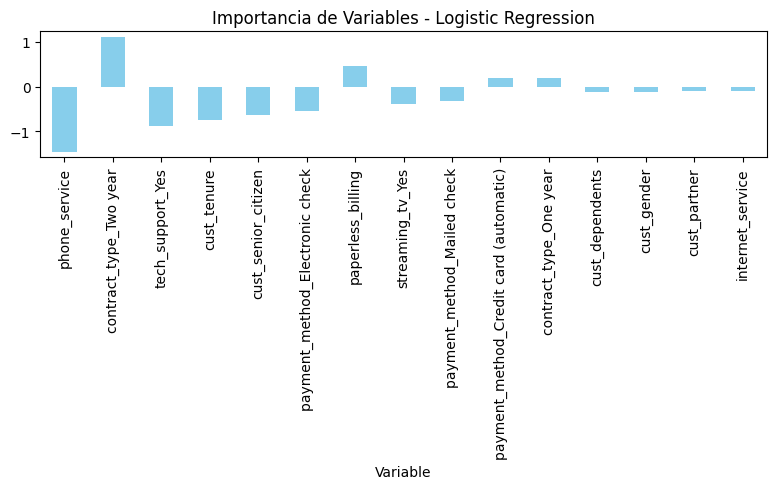


Top variables para Logistic Regression:
                   Variable  Importancia
17           phone_service    -1.459203
8   contract_type_Two year     1.110134
4         tech_support_Yes    -0.874472
16             cust_tenure    -0.757656
13     cust_senior_citizen    -0.647153


<Figure size 800x500 with 0 Axes>

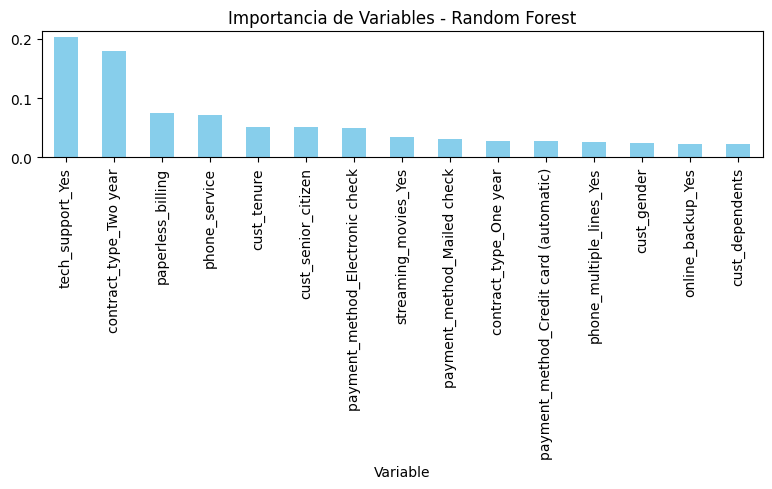


Top variables para Random Forest:
                   Variable  Importancia
4         tech_support_Yes     0.202708
8   contract_type_Two year     0.178817
19       paperless_billing     0.075481
17           phone_service     0.070991
16             cust_tenure     0.051556


<Figure size 800x500 with 0 Axes>

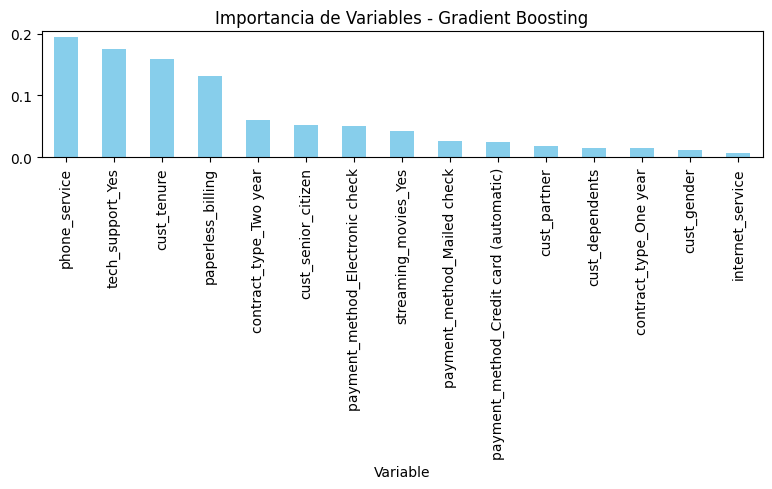


Top variables para Gradient Boosting:
                   Variable  Importancia
17           phone_service     0.193812
4         tech_support_Yes     0.175056
16             cust_tenure     0.158075
19       paperless_billing     0.131002
8   contract_type_Two year     0.059900


In [131]:
for nombre, modelo in modelos.items():
    # Crear pipeline con el modelo actual
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocesador),
        ('smote', SMOTE(random_state=42)),
        ('model', modelo)
    ])
    pipeline.fit(X_train, y_train)

    df_importancia = importancia_variables(pipeline, nombre, X_train, y_train)
    print(f"\nTop variables para {nombre}:\n", df_importancia.head())

Se concluye que las variables más importantes para los modelos fueron: phone_service, tech_support_Yes, cust_tenure, paperless_billing, contract_type_two year y además cust_senior_citizen para el modelo de regresión logística.

## CONCLUSIONES

- El modelo que mejor predijo la fuga de clientes fue el de Regresión Logística, con un recall de 77%.
- Las variables más importantes para la fuga de clientes son el tiempo de antiguedad del cliente, si tiene servicio telefónico, si cuenta con soporte técnico, si la facturación es virtual y la edad del cliente.
- Se sugiere que la empresa refuerce sus servicios telefónicos y de soporte técnico para evitar fugas; asimismo, que promueva la firma de contratos de larga duración o que incentive la renovación de contratos con premios o beneficios para los clientes más antiguos.